In [9]:
# If BCGunet not found, clone it (for Colab)
import os
import subprocess

if not os.path.exists("bcgunet"):
    subprocess.run(["git", "clone", "--depth", "1", "https://github.com/JacobLinCool/BCGunet.git", "./.repo"])
    subprocess.run(["mv", "./.repo/bcgunet", "."])

In [10]:
# Download dataset if not present
import hashlib
import os
import requests
from tqdm import tqdm


DATASET_PATH = os.path.normpath("./data/EyeClose1_noscan.mat")
DATASET_URL = "https://bcgunet-data.csie.cool/EyeClose1_noscan.mat"


if not os.path.exists("data"):
    os.makedirs("data")
if not os.path.exists(DATASET_PATH):
    res = requests.get(DATASET_URL, stream=True)
    with tqdm.wrapattr(
        open(DATASET_PATH, "wb"),
        "write",
        miniters=1,
        desc="Downloading dataset",
        total=int(res.headers.get("content-length", default="0")),
    ) as file:
        for chunk in res.iter_content(chunk_size=4096):
            file.write(chunk)
        file.close()
    SHA = "d36a16ad45302971843a6d413eb833f407fd4146c3e32dfe23bdd8a17ccba2cb"
    assert (
        SHA == hashlib.sha256(open(DATASET_PATH, "rb").read()).hexdigest()
    ), "Dataset is corrupted!"
    print("Dataset downloaded!")
else:
    print("Dataset already exists!")

Dataset already exists!


In [11]:
# install the following package
#!pip install  torch numpy scikit-learn h5py PyWavelets

# Step 1: loading mat file
import os
import numpy as np
import h5py
from bcgunet import bcgunet

if not os.path.exists(DATASET_PATH):
    print("Please put the data file at ", DATASET_PATH)
    raise FileNotFoundError

f = h5py.File(DATASET_PATH, "r")
ECG = np.array(f["ECG"]).flatten()
EEG = np.array(f["EEG_before_bcg"]).T
EEG_OBS = np.array(f["EEG"]).T

print(ECG.shape)
print(EEG.shape)

(934200,)
(31, 934200)


In [12]:
# Step 2: Get BCG from EEG and ECG
# (input_eeg, input_ecg, sfreq=5000, iter_num=5000, winsize_sec=2, lr=1e-3, onecycle=True)
# BCG = bcgunet.run(EEG, ECG, iter_num=10000)
# BCG = bcgunet.run(EEG) run it without ECG
EEG_unet = bcgunet.run(EEG, ECG)

Loss 196.694, lr: 0.00000: 100%|██████████| 5000/5000 [06:03<00:00, 13.76it/s]


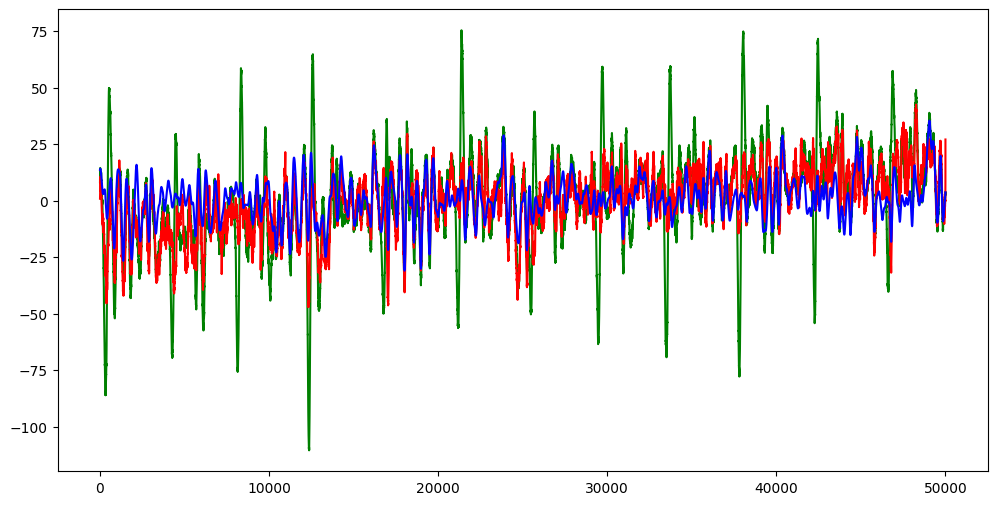

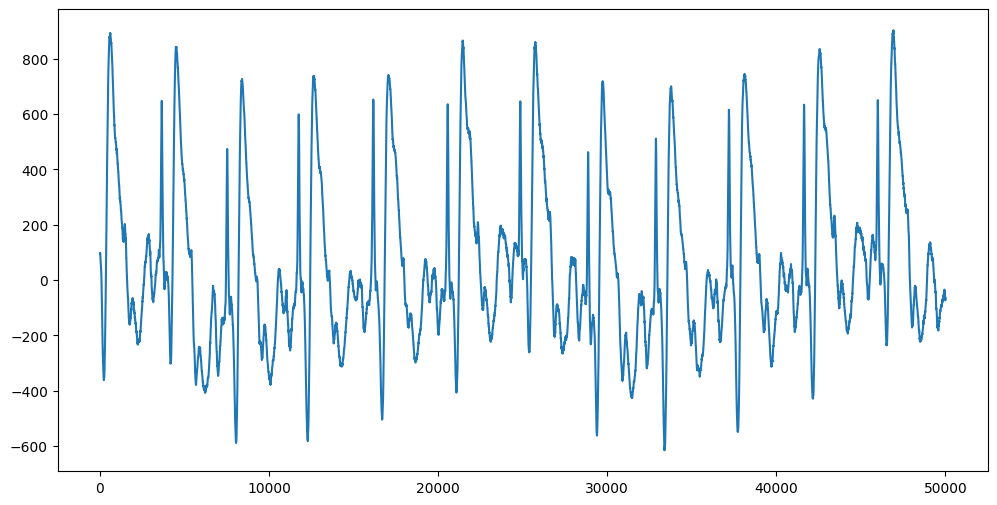

In [13]:
# Step 3: Plot EEG-BCG
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6), dpi=100)

plt.plot(EEG[19, -50000:], "g")
plt.plot(EEG_unet[19, -50000:], "r")
plt.plot(EEG_OBS[19, -50000:], "b")
plt.show()

plt.figure(figsize=(12, 6), dpi=100)
plt.plot(ECG[-50000:])
plt.show()

  0%|          | 0/31 [00:00<?, ?it/s]C:\Users\Pascal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\pywt\_functions.py:180: RuntimeWarning: divide by zero encountered in true_divide
  return central_frequency(wavelet, precision=precision) / scale
100%|██████████| 31/31 [00:51<00:00,  1.66s/it]


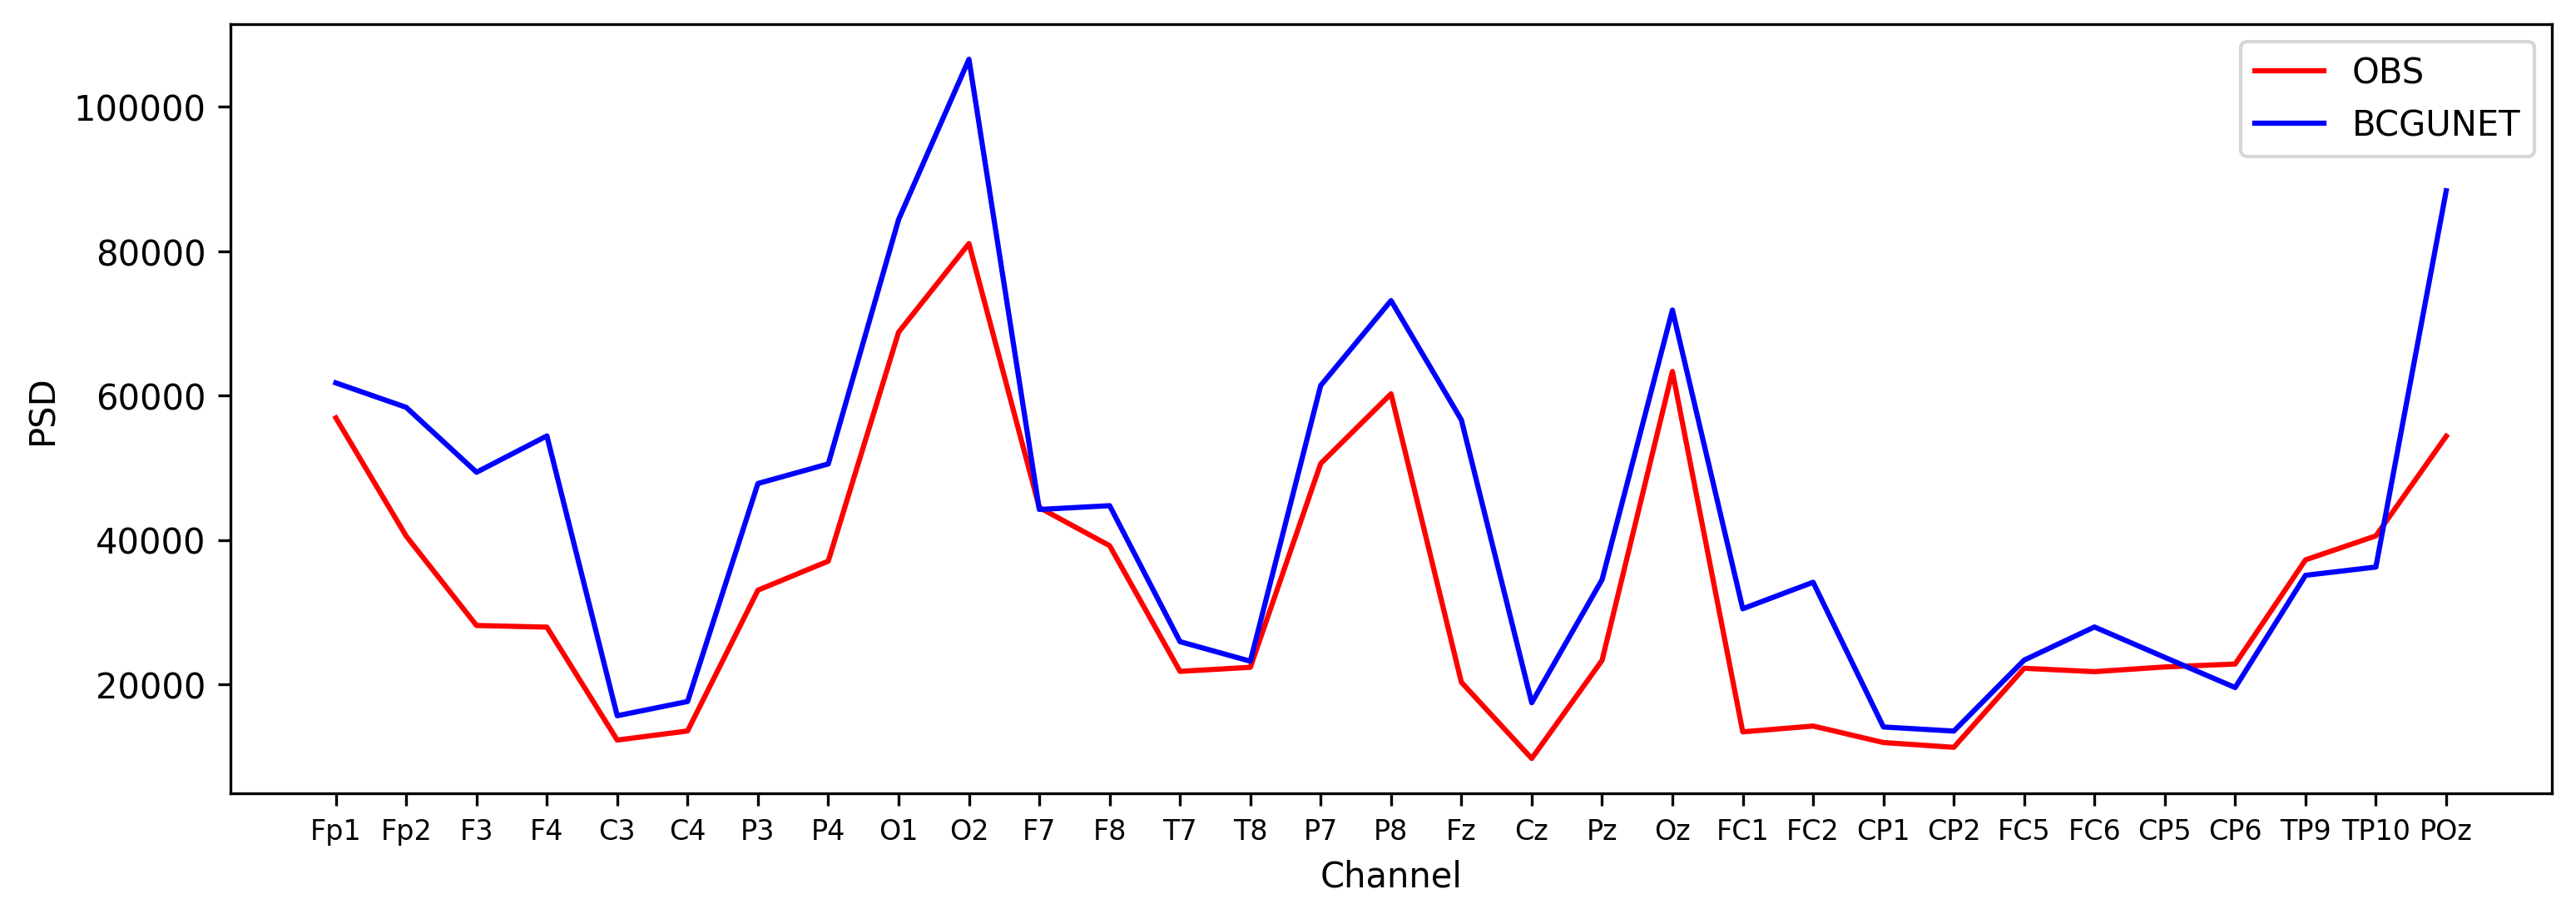

In [14]:
psd_obs = bcgunet.get_psd(EEG_OBS)
psd_unet = bcgunet.get_psd(EEG_unet)
label = [
    "Fp1",
    "Fp2",
    "F3",
    "F4",
    "C3",
    "C4",
    "P3",
    "P4",
    "O1",
    "O2",
    "F7",
    "F8",
    "T7",
    "T8",
    "P7",
    "P8",
    "Fz",
    "Cz",
    "Pz",
    "Oz",
    "FC1",
    "FC2",
    "CP1",
    "CP2",
    "FC5",
    "FC6",
    "CP5",
    "CP6",
    "TP9",
    "TP10",
    "POz",
]
plt.figure(figsize=(12, 4), dpi=300)
plt.plot(psd_obs, "r", label="OBS")
plt.plot(psd_unet, "b", label="BCGUNET")
plt.xlabel("Channel")
plt.ylabel("PSD")
plt.xticks(np.arange(31), label, fontsize=8)
plt.legend()